# Imports

In [1]:
import os
import h5py
import sympy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math
from scipy.interpolate import CubicSpline

from tree import SVTree
from nodes import FunctionNode
from regressor import SVRegressor

# Setup

In [60]:
basePath = os.path.join('results', 'mo_bugfix2_add_ffg_ffg_100')
fromArchive = False

basePath = os.path.join('results', 'mo_bugfix2')
fromArchive = True

In [61]:
if fromArchive:
    allTreeNames = glob.glob(os.path.join(basePath, '*'))
    del allTreeNames[allTreeNames.index(os.path.join(basePath, 'archive.pkl'))]
    
    bestCost = np.inf
    bestIdx = 0
    
    worstCost = 0
    worstIdx = 0
    
    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    
    allErrors = []
    allLatex = []

    for i, treePath in enumerate(allTreeNames):
        treeName = os.path.split(treePath)[-1]
        
        tree = pickle.load(open(os.path.join(treePath, 'tree.pkl'), 'rb'))

        entry = archive[treeName]
        tree.bestParams = entry.bestParams

        errors = entry.bestErrors
    
        latex = SVTree([
            FunctionNode(n.description) if isinstance(n, FunctionNode)
            else n
            for n in tree.nodes
        ]).latex()

        sumErrors = np.sum(errors)
        
        if sumErrors < bestCost:
            bestCost = sumErrors
            bestIdx = i
        
        if sumErrors > worstCost:
            worstCost = sumErrors
            worstIdx = i
        
        allErrors.append(sumErrors)
        allLatex.append(latex)
        
    allLatex = np.array(allLatex)[np.argsort(allErrors)]
    allErrors = np.array(allErrors)[np.argsort(allErrors)]

    for latex, errors in zip(allLatex, allErrors):
                display(Math('{:.2f}<->{}'.format(
            errors,
            sympy.latex(sympy.sympify(latex, evaluate=False), mul_symbol='dot')
        )))
            
    treePath = allTreeNames[bestIdx]
#     treePath = allTreeNames[worstIdx]
    treeName = os.path.split(treePath)[-1]

    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    tree = pickle.load(open(os.path.join(basePath, treeName, 'tree.pkl'), 'rb'))
    
    entry = archive[treeName]
    tree.bestParams = entry.bestParams
    
    errors = entry.bestErrors
else:
    files = sorted(glob.glob(os.path.join(basePath, 'tree*')))
    intIndices = [int(s[s.find('tree')+5:s.find('.pkl')]) for s in files]

    argsort = np.argsort(intIndices)

    treeFile = np.array(files)[argsort][-1]
    tree = pickle.load(open(treeFile, 'rb'))
    
    errorFiles = sorted(glob.glob(os.path.join(basePath, 'errors*')))
    errorFile  = np.array(errorFiles)[argsort][-1]
    errors = pickle.load(open(errorFile, 'rb'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [62]:
print('Best tree:', tree)

Best tree: add(ffg, ffg)


# Plotting

In [63]:
def plotSpline(x, y, bc):
    cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
    
    plotX = np.linspace(x[0], x[-1], 100)
    plotY = cs(plotX)
    
    return plotX, plotY

In [64]:
splits = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+len(svNode.restrictions[comp]))

In [65]:
splitParams = np.array_split(tree.fillFixedKnots(tree.bestParams)[0], np.cumsum(splits)[:-1])

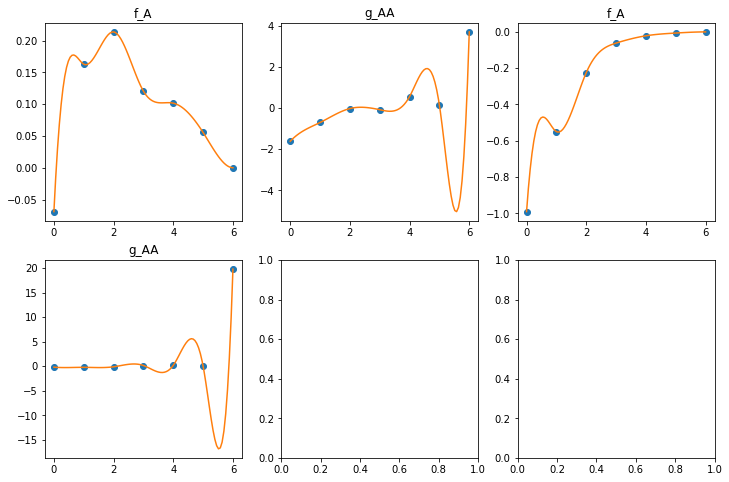

In [66]:
numRows = int(max(1, np.ceil(len(splitParams)/3)))

fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

compNames = np.hstack([svNode.components for svNode in tree.svNodes])

for i, spline in enumerate(splitParams):
    y, bc = spline[:-2], spline[-2:]
    x = np.arange(len(y))
    
    plotX, plotY = plotSpline(x, y, bc)
    
    row = i//3
    col = i%3
    
    if numRows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
    
    ax.plot(x, y, 'o')
    ax.plot(plotX, plotY)
    ax.set_title(compNames[i].decode('utf-8'))

# Errors

## Directly from logs

In [68]:
energyWeight = 10
forcesWeight = 1

unweighted = errors.copy()
unweighted[::2] /= energyWeight
unweighted[1::2] /= forcesWeight

np.sum(unweighted)

38.17579452094006

In [69]:
with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
        
    print(
        '{:>45} average errors || {:.6f} {:.6f}\n'.format(
            str(tree),
            np.sqrt(np.average(unweighted[::2]**2)),
            np.sqrt(np.average(unweighted[1::2]**2)),
        )
    )
    
    print(
        '{:>60} || {} {}'.format(
            'structName',
            '(eV/atom)',
            '(eV/A)'
        )
    )
    
    for i, structName in enumerate(sorted(db)):
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                unweighted[2*i],
                unweighted[2*i+1]
            )
        )

                                add(ffg, ffg) average errors || 0.007729 0.256887

                                                  structName || (eV/atom) (eV/A)
                                        Ground_state_crystal || 0.000000 0.017422
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.004340 0.016422
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.004277 0.015787
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.001105 0.023686
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.000265 0.028482
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.006449 0.035357
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.001295 0.018431
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.000096 0.019206
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.004360 0.017437
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.004341 0.017487
                

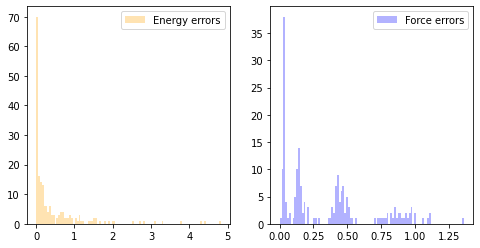

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(errors[::2] , bins=100, alpha=0.3, label='Energy errors', color='orange')
ax[1].hist(errors[1::2], bins=100, alpha=0.3, label='Force errors', color='blue')

ax[0].legend()
ax[1].legend()

## External validation

In [12]:
tree.bestParams.shape

(36,)

In [13]:
popDict = tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=False)

for svName in popDict:
    for bondType in popDict[svName]:
        popDict[svName][bondType] = [popDict[svName][bondType]]

In [14]:
def buildSVNodePool(group):
    """Prepare svNodePool for use in tree construction"""

    svNodePool = []

    # `group` is a pointer to an entry for a structure in the database
    for svName in sorted(group):
        svGroup = group[svName]

        restrictions = None
        if 'restrictions' in svGroup.attrs:
            restrictions = []
            resList = svGroup.attrs['restrictions'].tolist()
            for num in svGroup.attrs['numRestrictions']:
                tmp = []
                for _ in range(num):
                    tmp.append(tuple(resList.pop()))
                restrictions.append(tmp)

        svNodePool.append(
            SVNode(
                description=svName,
                components=svGroup.attrs['components'],
                numParams=svGroup.attrs['numParams'],
                bonds={
                    k:svGroup[k].attrs['components'] for k in svGroup.keys()
                },
                restrictions=restrictions,
                paramRanges=svGroup.attrs['paramRanges']\
                    if 'paramRanges' in group[svName].attrs else None
            )
        )

    return svNodePool

In [15]:
import cma

from mpi4py import MPI

from nodes import SVNode
from settings import Settings
from database import SVDatabase
from evaluator import SVEvaluator
from regressor import SVRegressor

settingsPath = 'examples/settings.in'
databasePath = '../svreg_data/mlearn/Mo/Mo.hdf5'

settings = Settings.from_file(settingsPath)
settings['PROCS_PER_PHYS_NODE'] = 1
settings['PROCS_PER_MANAGER'] = 1

worldComm = MPI.COMM_WORLD
with SVDatabase(settings['databasePath'], 'r') as database:
    structNames = list(database.keys())
#     structNames = ['Ground_state_crystal']

    if settings['refStruct'] not in structNames:
        raise RuntimeError(
            "The reference structure must be included in structNames."
        )

    evaluator =  SVEvaluator(worldComm, structNames, settings)
    evaluator.distributeDatabase(database)

    trueValues = database.loadTrueValues()

#     numStructs = len(trueValues)
    
    refStruct = settings['refStruct']
    treeErrors = np.zeros(2*len(database))
    
    svNodePool = buildSVNodePool(database[settings['refStruct']])
    
    regressor = SVRegressor(
        settings, svNodePool, cma.CMAEvolutionStrategy, [1.0, {'popsize': 1}]
    )
    
    regressor.trees = [tree]
    
    treePopulations = [tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=False)]
    
    # Group all dictionaries into one
    populationDict = {}
    for svNode in svNodePool:
        populationDict[svNode.description] = {}
        for bondType in svNode.bonds:
            populationDict[svNode.description][bondType] = []

    for treeDict in treePopulations:
        for svName in treeDict.keys():
            for bondType, pop in treeDict[svName].items():
                populationDict[svName][bondType].append(pop)
                            
    svEng = evaluator.evaluate(populationDict, evalType='energy')
    svFcs = evaluator.evaluate(populationDict, evalType='forces')
    
    energies, forces = regressor.evaluateTrees(svEng, svFcs, 1)
    
    for structName in sorted(structNames):
        eng = energies[structName][0] - energies[refStruct][0]
        fcs =   forces[structName][0]
        
        engErrors = eng - trueValues[structName]['energy']
        fcsErrors = fcs - trueValues[structName]['forces']
        
        treeErrors[2*i]   = abs(engErrors)
        treeErrors[2*i+1] = np.average(np.abs(fcsErrors), axis=(1, 2))
        
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                treeErrors[2*i],
                treeErrors[2*i+1]
            )
        )
# del evaluator

                                        Ground_state_crystal || 0.000000 0.030688
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.003753 0.028177
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.004587 0.032876
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.000000 0.042934
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.006080 0.057486
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.000139 0.074919
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.000065 0.029378
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.000073 0.040623
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.003741 0.025258
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.004600 0.036328
                         Mo_3x3x3_cell_mode_2_strain_-0.0600 || 0.000180 0.046811
                         Mo_3x3x3_cell_mode_2_strain_-0.0800 || 0.006216 0.055115
                

In [19]:
treeErrors.sum()

0.8351426211278248

In [ ]:
del evaluator